Text(0.5, 0.98, 'Input and Output Data Samples - BACKWARD PASS')

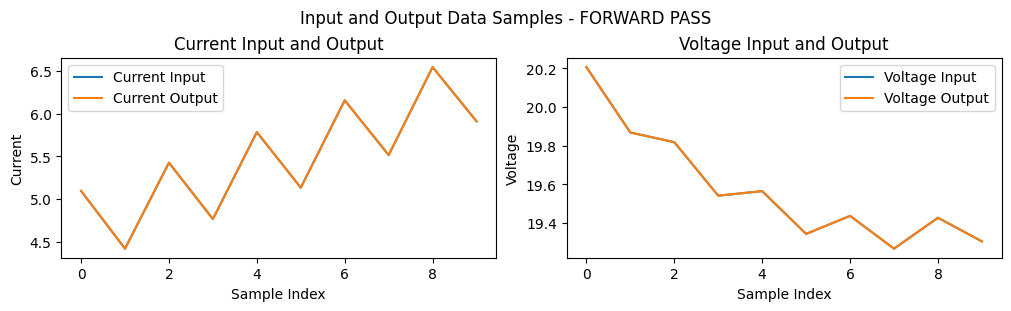

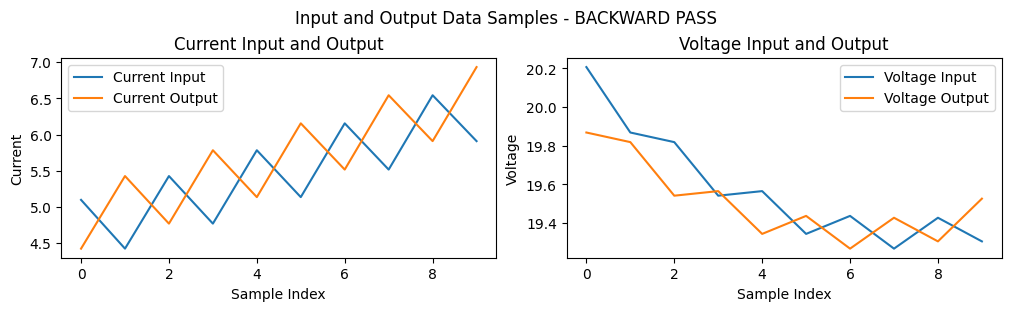

In [1]:
from __future__ import annotations

import argparse
import time
from pathlib import Path
from typing import Tuple, List

import numpy as np
import scipy.io as sio
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from clss.blueprints import DataStructure


seed = 1234


np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

# Data path
simulation_data_path = Path(r"Simulation_data") / "buckSimulation_0.mat"
data = DataStructure.from_dict(sio.loadmat(simulation_data_path))


x0 = np.stack(
    [
        data.x_current[::2],
        data.x_volt[::2],
        data.d_switch[::2],
        1 - data.d_switch[::2],
        data.dt[::2],
    ],
    axis=1,
)

u0 = np.stack(
    [
        data.y_current[::2],
        data.y_volt[::2],
    ],
    axis=1,
)

x1 = np.stack(
    [
        data.x_current[1::2],
        data.x_volt[1::2],
        data.d_switch[1::2],
        1 - data.d_switch[1::2],
        data.dt[1::2],
    ],
    axis=1,
)

u1 = np.stack(
    [
        data.y_current[1::2],
        data.y_volt[1::2],
    ],
    axis=1,
)

# This is the data fed to the model
# inspect the current data: 

fig, ax = plt.subplots(1, 2, figsize=(10, 3), constrained_layout=True)

ax[0].plot(x0[:10, 0], label="Current Input")
ax[0].plot(u0[:10, 0], label="Current Output")
ax[0].set_title("Current Input and Output")
ax[0].set_xlabel("Sample Index")
ax[0].set_ylabel("Current")
ax[0].legend()

ax[1].plot(x0[:10, 1], label="Voltage Input")
ax[1].plot(u0[:10, 1], label="Voltage Output")
ax[1].set_title("Voltage Input and Output")
ax[1].set_xlabel("Sample Index")
ax[1].set_ylabel("Voltage")
ax[1].legend()

fig.suptitle("Input and Output Data Samples - FORWARD PASS")


fig, ax = plt.subplots(1, 2, figsize=(10, 3), constrained_layout=True)
ax[0].plot(x1[:10, 0], label="Current Input")
ax[0].plot(u1[:10, 0], label="Current Output")
ax[0].set_title("Current Input and Output")
ax[0].set_xlabel("Sample Index")
ax[0].set_ylabel("Current")
ax[0].legend()

ax[1].plot(x1[:10, 1], label="Voltage Input")
ax[1].plot(u1[:10, 1], label="Voltage Output")
ax[1].set_title("Voltage Input and Output")
ax[1].set_xlabel("Sample Index")
ax[1].set_ylabel("Voltage")
ax[1].legend()
fig.suptitle("Input and Output Data Samples - BACKWARD PASS")

In [8]:
print(data_dict.keys())

dict_keys(['__header__', '__version__', '__globals__', 'Current', 'CurrentInput', 'CurrentInputLower', 'Dswitch', 'DswitchLower', 'DswitchTransform', 'Rload', 'RloadLower', 'Voltage', 'VoltageInput', 'VoltageInputLower', 'dt', 'forwaredBackwaredIndicator', 'res', 't', 'tLower'])


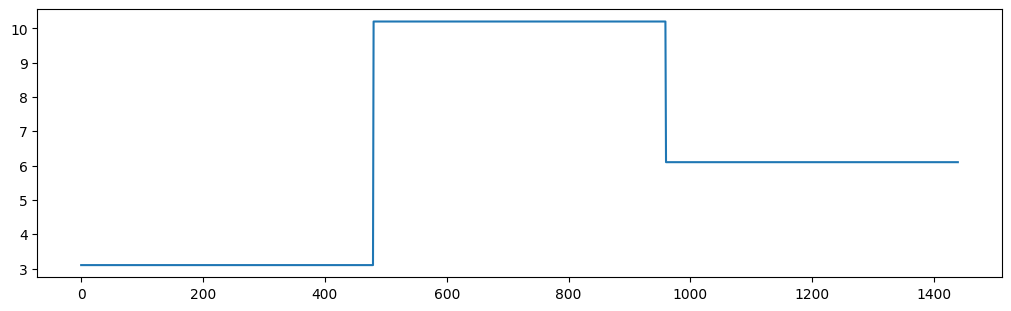

In [ ]:
data_dict = sio.loadmat(simulation_data_path)

rload = data_dict["Rload"][:]

fig, ax = plt.subplots(1, 1, figsize=(10, 3), constrained_layout=True)
ax.plot(rload, label="Rload")


In [29]:
x0 = np.stack(
    [
        data.x_current[::2],
        data.x_volt[::2],
        data.d_switch[::2],
        1 - data.d_switch[::2],
        data.dt[::2],
    ], axis =1
)

u0 = np.stack(
    [
        data.y_current[::2],
        data.y_volt[::2],
    ], axis = 1
)

x1 = np.stack(
    [
        data.x_current[1::2],
        data.x_volt[1::2],
        data.d_switch[1::2],
        1 - data.d_switch[1::2],
        data.dt[1::2],
    ], axis = 1
)

u1 = np.stack(
    [
        data.y_current[1::2],
        data.y_volt[1::2],
    ], axis = 1
)

dummy_x1 = np.stack(
    [
        data.x_current[idx_backward],
        data.x_volt[idx_backward],
        data.d_switch[idx_backward],
        1 - data.d_switch[idx_backward],
        data.dt[idx_backward],
    ], axis = 1
)

dummy_x0 = np.stack(
    [
        data.x_current[idx_forward],
        data.x_volt[idx_forward],
        data.d_switch[idx_forward],
        1 - data.d_switch[idx_forward],
        data.dt[idx_forward],
    ], axis = 1
)

print("x0 and dummy_x0 are equal: ", np.allclose(
    dummy_x0,
    x0,
))

print("x1 and dummy_x1 are equal: ", np.allclose(
    dummy_x1,
    x1,
))

x0.shape, u0.shape, x1.shape, u1.shape

x0 and dummy_x0 are equal:  True
x1 and dummy_x1 are equal:  True


((720, 5), (720, 2), (720, 5), (720, 2))

In [15]:
dummy_fw = np.arange(0, len(data.indicator[:,0]), 2)
dummy_bw = dummy_fw + 1
# idx_forward
np.allclose(idx_forward, dummy_fw), np.allclose(idx_backward, dummy_bw)

(True, True)

In [4]:
idx_backward.shape, idx_forward.shape, data.indicator.shape

((720,), (720,), (1440, 2))

In [9]:
data.indicator[:10, 1]

array([0, 0, 1, 1, 0, 0, 1, 1, 0, 0], dtype=int16)

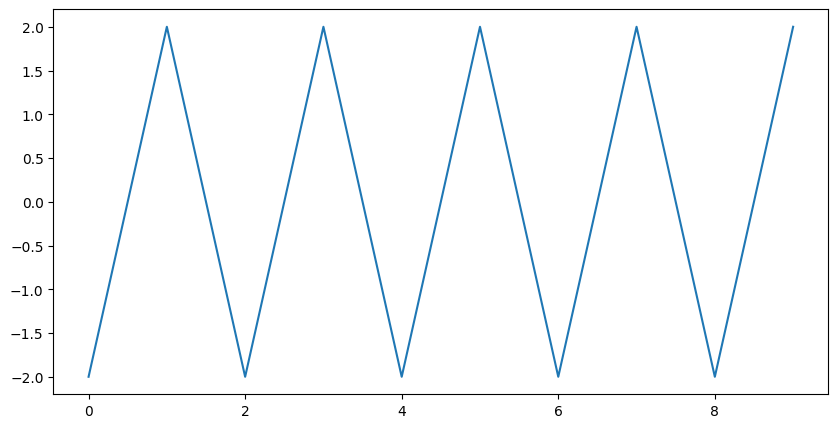

In [7]:
## plot indicator 
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(data.indicator[:10, 0], label="Indicator")

In [3]:
import pandas as pd

datadf = pd.DataFrame(data)

ValueError: Per-column arrays must each be 1-dimensional

In [ ]:
adam_epochs: int = 45_000
adam_lr: float = 1e-3
lbfgs_epochs: int = 50_000

# Nominal component values (Table I in the paper)
nL = 7.25
nRL = 3.14
nC = 1.645
nRC = 2.01
nRdson = 2.21
nRload1 = 3.1
nRload2 = 10.2
nRload3 = 6.1
nVin = 4.8
nVF = 1.0